In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns


# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

# import scaling methods
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split

# import modeling methods
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from scipy import stats

# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

## custome script imports
import acquire as a 
import prepare as p
import model as m

### Executive Summary

The purpose of this notebook is create a regression model that predicts professional counter strike player ratings form a dataset provided from ka


### Acquiring Player Data

In [2]:
df = a.get_player_data() ## using our acquire functionn 

In [3]:
df.head() ## previewing our data

,name,country,teams,total_maps,total_rounds,kd_diff,kd,rating
0,ZywOo,France,"['Vitality', 'aAa']",854,22399,5248,1.38,1.28
1,s1mple,Ukraine,"['Natus Vincere', 'FlipSid3']",1429,37717,8070,1.33,1.25
2,deko,Russia,['1WIN'],190,5096,1250,1.42,1.24
3,saffee,Brazil,['paiN'],202,5383,1211,1.37,1.24
4,sh1ro,Russia,"['Gambit', 'Gambit Youngsters']",744,19780,4593,1.43,1.22


#### Numerical Statistics Dataframe

In [4]:
stats_df = a.acquire_stats(df) ## using our custom function to output numerical statistics
## for the player stats dataframe

stats_df.head() ## previewing our numerical statistics dataframe

,count,mean,std,min,25%,50%,75%,max,range
total_maps,1869.0,435.231675,391.291072,100.00,152.00,271.00,592.00,2064.00,1964.0
total_rounds,1869.0,11399.083467,10298.045537,2348.00,3977.00,7076.00,15532.00,54137.00,51789.0
kd_diff,1869.0,180.254147,991.956591,-6238.00,-269.00,-32.00,352.00,8070.00,14308.0
kd,1869.0,0.996726,0.100515,0.63,0.93,0.99,1.06,1.43,0.8
rating,1869.0,0.985757,0.075545,0.68,0.94,0.99,1.03,1.28,0.6


#### Acquire Exploration: Data Types, Nulls, & Distributions

In [5]:
a.summarize_df(df) ## using our custom script function to look at data types and nulls

Info on Columns and Datatypes:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 0 to 1868
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          1869 non-null   object 
 1   country       1869 non-null   object 
 2   teams         1869 non-null   object 
 3   total_maps    1869 non-null   int64  
 4   total_rounds  1869 non-null   int64  
 5   kd_diff       1869 non-null   int64  
 6   kd            1869 non-null   float64
 7   rating        1869 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 131.4+ KB
None
------------------------------------------------

Value Counts for country:

United States    204
Brazil           138
Australia        134
Denmark          120
Russia           118
                ... 
Lebanon            1
Italy              1
Azerbaijan         1
Ireland            1
Hong Kong          1
Name: country, Length: 72, dtype: int64
---------------

Doesn't look like we have a lot of observations if there are any null values we will need to consider filling them to retain as many observations as possible

Distribution of total_maps



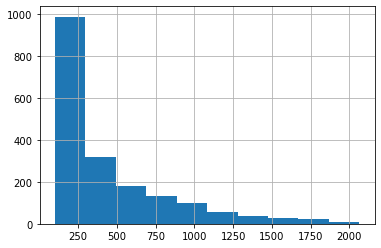

--------------------
Distribution of total_rounds



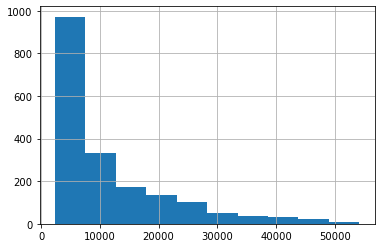

--------------------
Distribution of kd_diff



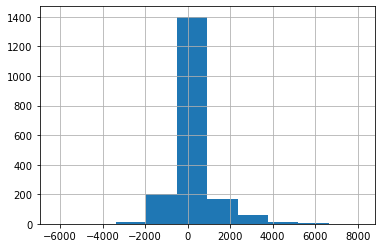

--------------------
Distribution of kd



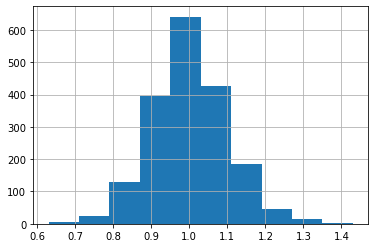

--------------------
Distribution of rating



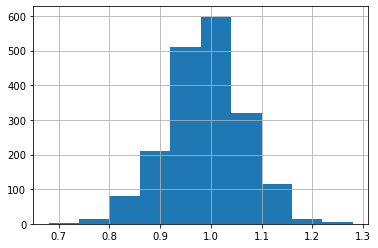

--------------------


In [6]:
## using our custom script funciton to look at distributions
a.univariate_distributions(df) 

The kd, kd diff, and rating of a player are relatively normally distributed.

The total maps and total rounds are tailing to the right.

### Acquire Takeaways

There are normally distributions in the numerical columns which we will verify correlations with statical testing to our target in exploration.

We have correct data types in the data frame already and don't need to do any conversions. However, we will need to check the string valued columns and make sure they don't have any trailing or leading white space because this will make exploration and modeling difficult to execute.

### Preparing Player Stats

First we will double check to make sure we have no nulls or duplicates withing our data. Since we have such a small amount of observations we will want to fill these if they are among the data.

In [7]:
df.isnull().sum() ## checking for null values

name            0
country         0
teams           0
total_maps      0
total_rounds    0
kd_diff         0
kd              0
rating          0
dtype: int64

In [8]:
df.duplicated().sum() ## checking for duplicate rows.

0

Now we can confirm we don't have any null values or duplicate rows and carry forward with splitting the data.

#### Stripping Spaces from String Columns

In [9]:
df = p.strip_strings(df) ## using our strip string function to make sure the string valued
## columns are clean and ready for exploration and modeling

#### Train, Validate, Test Splitting Data

In [10]:
## using our data split function to split into train validate, & test dataframes

train, validate, test = p.split_data(df) 

Making Sure Our Shapes Look Good
Train: (1046, 8), Validate: (449, 8), Test: (374, 8)


In [14]:
train.head() ## previewing train

,name,country,teams,total_maps,total_rounds,kd_diff,kd,rating
875,s0m,United States,"['Gen.G', 'Gen.G', 'Envy', 'Naventic']",358,9528,28,1.00,0.99
1507,S0tF1k,Russia,"['Spirit', 'Spirit', 'Espada']",1274,33567,-1878,0.92,0.92
739,pounh,Lithuania,"['Playing Ducks', 'Imperial', '1337HUANIA']",401,10552,91,1.01,1.00
1719,torben,Denmark,['Fragsters'],532,13939,-1196,0.87,0.88
593,TENZKI,Denmark,"['Nordavind', 'Dignitas', 'Rogue']",1469,38637,1372,1.05,1.02


In [13]:
validate.head() ## previewing validate

,name,country,teams,total_maps,total_rounds,kd_diff,kd,rating
817,ALEX,United Kingdom,"['LDLC', 'LDLC', 'Vitality']",1040,27531,-248,0.99,1.00
1392,DomiNate,Sweden,"['Publiclir.se', 'ArchAngels']",187,4922,-238,0.93,0.94
1648,sycrone,Denmark,"['Sprout', 'North Academy', 'Tricked', 'Team123']",553,14608,-978,0.90,0.90
804,cromen,Norway,['Nordavind'],653,17335,67,1.01,1.00
133,mixwell,Spain,"['OpTic', 'Movistar Riders']",840,21804,1911,1.13,1.09


In [15]:
test.head() ## previewing test

,name,country,teams,total_maps,total_rounds,kd_diff,kd,rating
1121,SEMINTE,Romania,"['Nexus', 'XPC']",607,15872,-366,0.97,0.97
582,MoeycQ,Australia,"['Immunity', 'Chiefs', 'Ground Zero', 'AVANT']",613,15920,410,1.04,1.02
43,zAAz,Sweden,"['Secret fe', 'Besiktas', 'Bad Monkey']",227,5502,606,1.16,1.13
898,Drone,United States,"['Splyce', 'Envy']",454,11841,-168,0.98,0.99
1083,b0bbzki,Sweden,"['Singularity', 'Gatekeepers', 'fightclub']",278,7248,-240,0.95,0.97


### Prepare Takeaways

Given the fact that I had a limited amount of observations I wanted to make sure to fill any nulls with averages or means. Thankfully after preparing the dataframe we didn't have any null values and were able to keep the original amount of observations.

Hypothesizing the kd_diff, kd, and total_rounds played will be good features to predict our end goal of player rating.

### Exploring Player Stats

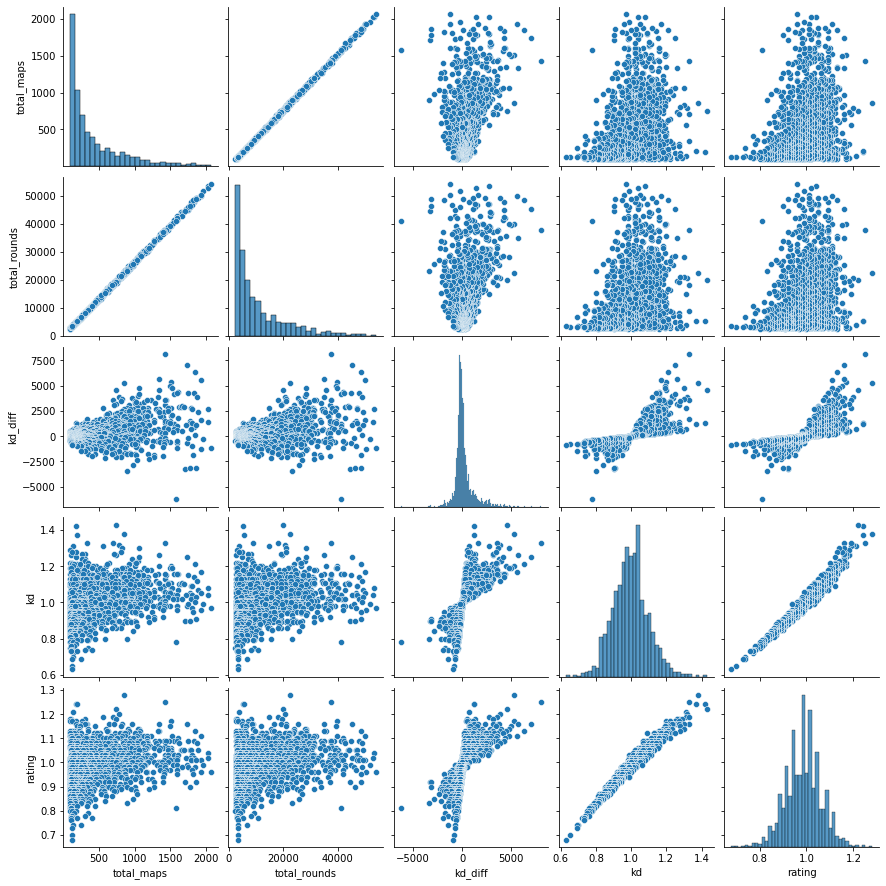

In [16]:
sns.pairplot(data = df) ## looking at our variable relationships
plt.show()

Looks like we have some really strong correlations with player rating and their kd (kill/death ratio)

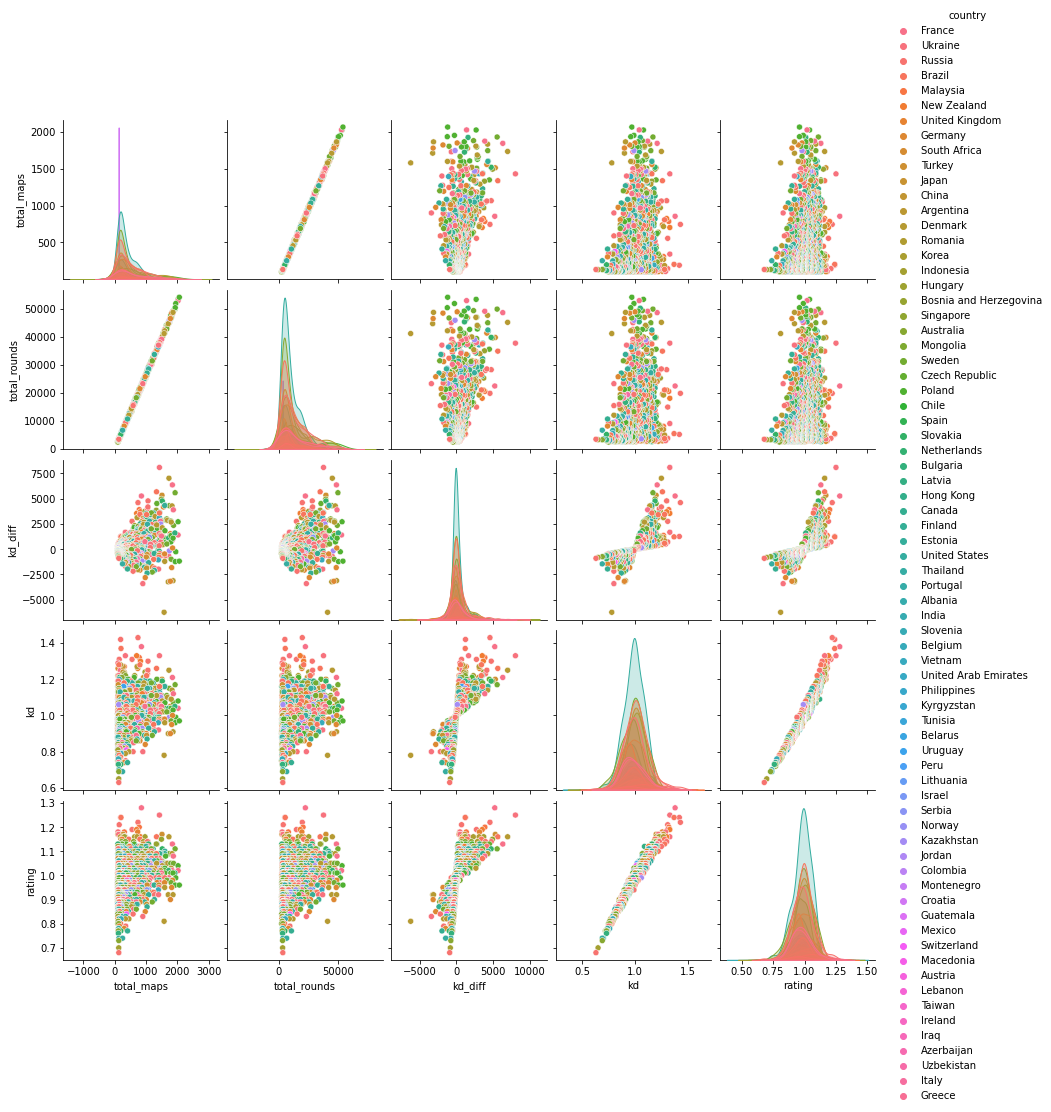

In [17]:
sns.pairplot(data = df, hue = 'country') ## looking at our variable relationships
plt.show()                               ## with country as a hue

Although this pairplot looks nice it is very hard to see anything significant due to the large amount of different countries players play for I should consider making subgroups for different countries for a clearer visual.

#### Exploring Correlations

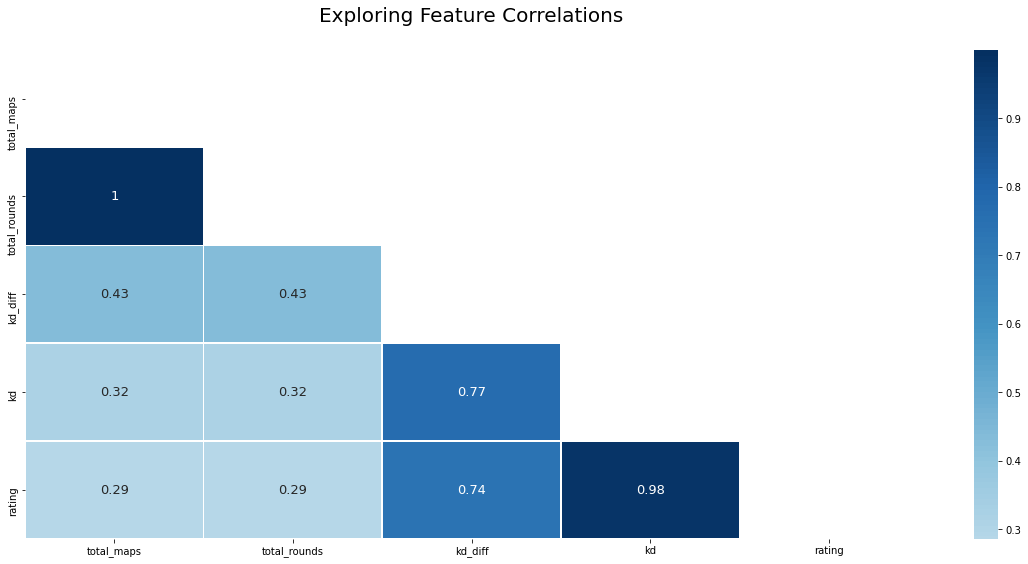

In [18]:
## defining correlation variable for heatmap
corr = train.corr()

## creating a heatmap of the correlation between all columns in our dataframe

plt.figure(figsize=(20,9))
mask = np.zeros_like(corr)  ## <-- creating a mask
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, annot=True, linewidths=.5, cmap='RdBu',
            annot_kws={"size": 13}, mask=mask)
plt.title('Exploring Feature Correlations\n', {'fontsize': 20})
plt.show()

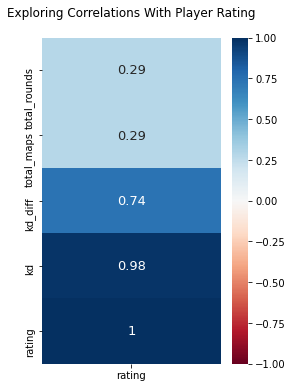

In [19]:
## Creating a heatmap showing correlations to our target variable

plt.figure(figsize = (4,6))  
sns.heatmap(train.corr()[['rating']].sort_values(by='rating', 
                                                        ascending = True), cmap = 'RdBu', 
            vmax = 1, vmin = -1, center = 0, 
            annot = True, annot_kws={"size": 13}, ec = 'black')
plt.title('Exploring Correlations With Player Rating\n')
plt.show()

Looks like the strongest correlations we have with our target variable are kd and kd_diff lets explore these further to see if they are significant and can be used in our model

#### Pearson R Correlation Testing

In [21]:
alpha = 0.05 ## <-- Determining alpha value

Correlation Tests of KD and KD_diff
 - To target variable: tax_value

Standard Hypothesis for correlation test of all variables

$H_0$ : There is no relationship between these variables

$H_a$ : There is evidence to suggest there is a realtionhip between these two variables

In [22]:
## performing correlation test on kd and rating because the heat map showed
## a good correlation value.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.rating, train.kd)
corr, p

(0.9800825424890092, 0.0)

With a high correlation of .98 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a significant realtionship between the kd of a player and their player rating, thus accepting the alternate hypothesis.


In [23]:
## performing correlation test on kd_diff and rating because the heat map showed
## a good correlation value.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.rating, train.kd_diff)
corr, p

(0.73634426586598, 2.4911015819407044e-179)

With a high correlation of .736 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a significant realtionship between the kd_diff of a player and their player rating, thus accepting the alternate hypothesis.


#### Explore Takeaways

We have some strong correlations between our target variable: player rating and kd and rating and kd_diff. These values were pearson r correlation tested and these correlations proved to be significant and not random.

Given how strong the correlations are and how limited our features are we are going to use these two features (kd, kd_diff) in our regresison modeling and score the metrics.

### Modeling

Regression Modeling

#### Splitting Into X and Y Dataframes

In [24]:
## Setting up X and y's by dropping target variable from X's and setting them to y

## also dropping unneccessary columns for predicting target variable


X_train, y_train = train.drop(columns = ['total_rounds', 'teams', 'country' ,'name', 'rating']), train.rating
X_validate, y_validate = validate.drop(columns = ['total_rounds', 'teams', 'country' ,'name', 'rating']), validate.rating
X_test, y_test = test.drop(columns = ['total_rounds', 'teams', 'country' ,'name', 'rating']), test.rating

In [25]:
X_train.head() ## previewing our x_train dataframe

,total_maps,kd_diff,kd
875,358,28,1.00
1507,1274,-1878,0.92
739,401,91,1.01
1719,532,-1196,0.87
593,1469,1372,1.05


In [26]:
y_train.head() ## previewing our y_train array

875     0.99
1507    0.92
739     1.00
1719    0.88
593     1.02
Name: rating, dtype: float64

In [27]:
## Turning all my y's into dataframe

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [28]:
y_train.head() ## looking our our target variable dataframe

,rating
875,0.99
1507,0.92
739,1.00
1719,0.88
593,1.02


#### Establishing Mean and Median Baseline¶


In [30]:
## rating mean
rating_pred_mean = y_train['rating'].mean()
y_train['rating_pred_mean'] = rating_pred_mean
y_validate['rating_pred_mean'] = rating_pred_mean

## rating median
rating_pred_median = y_train['rating'].median()
y_train['rating_pred_median'] = rating_pred_median
y_validate['rating_pred_median'] = rating_pred_median

## RMSE of rating mean train and validate scores
rmse_train = mean_squared_error(y_train.rating, y_train.rating_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.rating, y_validate.rating_pred_mean)**(1/2)

print('Baseline')
print('-----------------------------')
print('RMSE using Mean\nTrain/In-Sample: ', round(rmse_train, 4), 
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 4))
print('-----------------------------')

## RMSE of rating_pred_median train and validate scores
rmse_train = mean_squared_error(y_train.rating, y_train.rating_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.rating, y_validate.rating_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

## R squared score for baseline
print('-----------------------------')
r2_baseline = r2_score(y_validate.rating, y_validate.rating_pred_mean)
print(f'The R squared score for the baseline is {r2_baseline}')

Baseline
-----------------------------
RMSE using Mean
Train/In-Sample:  0.0748 
Validate/Out-of-Sample:  0.0773
-----------------------------
RMSE using Median
Train/In-Sample:  0.0748 
Validate/Out-of-Sample:  0.0774
-----------------------------
The R squared score for the baseline is -0.00011947189339411857


In [31]:
# create df to hold metrics
metrics_df = pd.DataFrame()

In [32]:
## adding our mean baseline to our metric dataframe
metrics_df = m.get_metrics(metrics_df, 'mean_baseline',rmse_validate,explained_variance_score(y_validate.rating, y_validate.rating_pred_median))

In [33]:
metrics_df ## previewing our metrics df

,model,r^2_outofsample,rmse_outofsample
0,mean_baseline,0.0,0.077376


#### LinearRegression/OLS¶

In [34]:
## create the model
lm = LinearRegression(normalize = True)

## fit the model to train
lm.fit(X_train, y_train.rating)

## use the model to predict train
y_train['rating_pred_lm'] = lm.predict(X_train)

## RMSE score for train
rmse_train = mean_squared_error(y_train.rating, 
                                y_train.rating_pred_lm) **(1/2)

## predict validate 
y_validate['rating_pred_lm'] = lm.predict(X_validate)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.rating, 
                                y_validate.rating_pred_lm) **(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for OLS: {r2_score(y_validate.rating, y_validate.rating_pred_lm)}')

RMSE for OLS using LinearRegression
Training/In-Sample:  0.014665625049398648 
Validate/Out-of-Sample:  0.013488588175140866
------------------------------------------------
R squared score for OLS: 0.9695344872412925


In [36]:
## adding our OLS scores to our metric dataframe
metrics_df = m.get_metrics(metrics_df, 'OLS_Linear_Regression',rmse_validate,explained_variance_score(y_validate.rating, y_validate.rating_pred_lm))

In [37]:
metrics_df ## previewing metric df

,model,r^2_outofsample,rmse_outofsample
0,mean_baseline,0.000000,0.077376
1,OLS_Linear_Regression,0.969622,0.013489


#### Lasso & Lars¶


In [38]:
## create the model
lars = LassoLars(alpha=1.0)

## fit the model to train
lars.fit(X_train, y_train.rating)

## use the model to predict train
y_train['rating_pred_lars'] = lm.predict(X_train)

## RMSE score for train
rmse_train = mean_squared_error(y_train.rating, 
                                y_train.rating_pred_lars) **(1/2)

## predict validate 
y_validate['rating_pred_lars'] = lars.predict(X_validate)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.rating, 
                                y_validate.rating_pred_lars) **(1/2)

print("RMSE for Lasso & Lars Model\nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for Lasso & Lars: {r2_score(y_validate.rating, y_validate.rating_pred_lars)}')

RMSE for Lasso & Lars Model
Training/In-Sample:  0.014665625049398648 
Validate/Out-of-Sample:  0.07728375066314568
------------------------------------------------
R squared score for Lasso & Lars: -0.00011947189339411857


In [39]:
## adding our Lasso Lars scores to our metric dataframe
metrics_df = m.get_metrics(metrics_df, 'Lasso_Lars',rmse_validate,explained_variance_score(y_validate.rating, y_validate.rating_pred_lars))

In [40]:
## previewing our scores
metrics_df

,model,r^2_outofsample,rmse_outofsample
0,mean_baseline,0.000000,0.077376
1,OLS_Linear_Regression,0.969622,0.013489
2,Lasso_Lars,0.000000,0.077284


#### TweedieRegressor

In [41]:
## create the model
glm = TweedieRegressor(power = 0, alpha = 0)

## fit the model to train
glm.fit(X_train, y_train.rating)

## use the model to predict train
y_train['rating_pred_glm'] = lm.predict(X_train)

## RMSE score for train
rmse_train = mean_squared_error(y_train.rating, 
                                y_train.rating_pred_glm) **(1/2)

## predict validate 
y_validate['rating_pred_glm'] = glm.predict(X_validate)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.rating, 
                                y_validate.rating_pred_glm) **(1/2)

print("RMSE for Tweedie Regressor\nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for Tweedie. Regressor: {r2_score(y_validate.rating, y_validate.rating_pred_glm)}')

RMSE for Tweedie Regressor
Training/In-Sample:  0.014665625049398648 
Validate/Out-of-Sample:  0.013488594143717721
------------------------------------------------
R squared score for Tweedie. Regressor: 0.9695344602798652


In [43]:
## adding our tweedie regressor scores to our metric dataframe
metrics_df = m.get_metrics(metrics_df, 'Tweedie_Regressor',rmse_validate,explained_variance_score(y_validate.rating, y_validate.rating_pred_glm))

In [44]:
## previewing our scores

metrics_df

,model,r^2_outofsample,rmse_outofsample
0,mean_baseline,0.000000,0.077376
1,OLS_Linear_Regression,0.969622,0.013489
2,Lasso_Lars,0.000000,0.077284
3,Tweedie_Regressor,0.969622,0.013489


#### Polynomial Regression¶


In [45]:
## getting new set of features using degree 2
pf = PolynomialFeatures(degree = 2)

## fitting and transforming scaled X's for lm2 below
X_train_degree2 = pf.fit_transform(X_train)
X_validate_degree2 = pf.fit_transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [46]:
## create the model
lm2 = LinearRegression(normalize = True)

## fit the model to train
lm2.fit(X_train, y_train.rating)

## use the model to predict train
y_train['rating_pred_lm2'] = lm2.predict(X_train)

## RMSE score for train
rmse_train = mean_squared_error(y_train.rating, 
                                y_train.rating_pred_lm2) **(1/2)

## predict validate 
y_validate['rating_pred_lm2'] = lm2.predict(X_validate)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.rating, 
                                y_validate.rating_pred_lm2) **(1/2)

print("RMSE for 2nd Degree Polynomial Regression\nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for 2nd Degree Polynomial Regression: {r2_score(y_validate.rating, y_validate.rating_pred_lm2)}')

RMSE for 2nd Degree Polynomial Regression
Training/In-Sample:  0.014665625049398648 
Validate/Out-of-Sample:  0.013488588175140866
------------------------------------------------
R squared score for 2nd Degree Polynomial Regression: 0.9695344872412925


In [47]:
## adding our 2nd degree polynomail regressions scores to our metric dataframe
metrics_df = m.get_metrics(metrics_df, '2nd_degree_polynomial',rmse_validate,explained_variance_score(y_validate.rating, y_validate.rating_pred_lm2))

In [48]:
metrics_df ## previewing our scores

,model,r^2_outofsample,rmse_outofsample
0,mean_baseline,0.000000,0.077376
1,OLS_Linear_Regression,0.969622,0.013489
2,Lasso_Lars,0.000000,0.077284
3,Tweedie_Regressor,0.969622,0.013489
4,2nd_degree_polynomial,0.969622,0.013489


In [49]:
metrics_df.sort_values(by = 'rmse_outofsample', ascending = True)

,model,r^2_outofsample,rmse_outofsample
1,OLS_Linear_Regression,0.969622,0.013489
4,2nd_degree_polynomial,0.969622,0.013489
3,Tweedie_Regressor,0.969622,0.013489
2,Lasso_Lars,0.000000,0.077284
0,mean_baseline,0.000000,0.077376


Looks like the top 3 models performed similarly.

Top 3 Models
 - OLS
 - 2nd Degree Polynomial
 - Tweedie_Regressor

#### Plotting The Residuals 

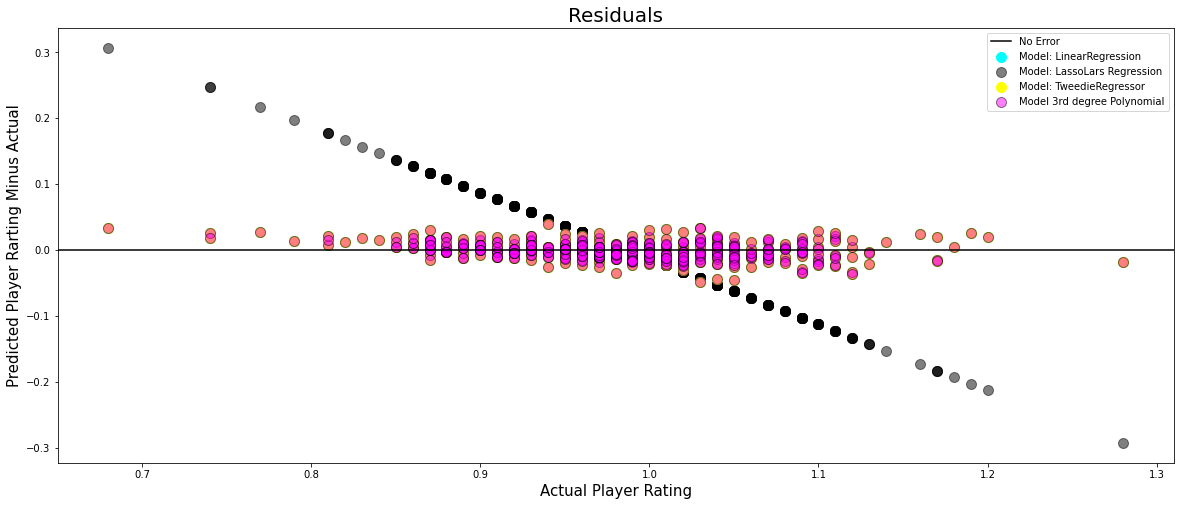

In [52]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error", color="black")
plt.scatter(y_validate.rating, y_validate.rating_pred_lm-y_validate.rating, 
            alpha=1, color="cyan", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.rating, y_validate.rating_pred_lars-y_validate.rating, 
            alpha=.5, color="black", s=100, label="Model: LassoLars Regression")
plt.scatter(y_validate.rating, y_validate.rating_pred_glm-y_validate.rating, 
            alpha=1, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.rating, y_validate.rating_pred_lm2-y_validate.rating, 
            alpha=.5, color="magenta", s=100, edgecolors='black', label="Model 3rd degree Polynomial")
plt.legend()

plt.xlabel("Actual Player Rating", fontdict={'fontsize':15})
plt.ylabel("Predicted Player Rarting Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})
plt.show()

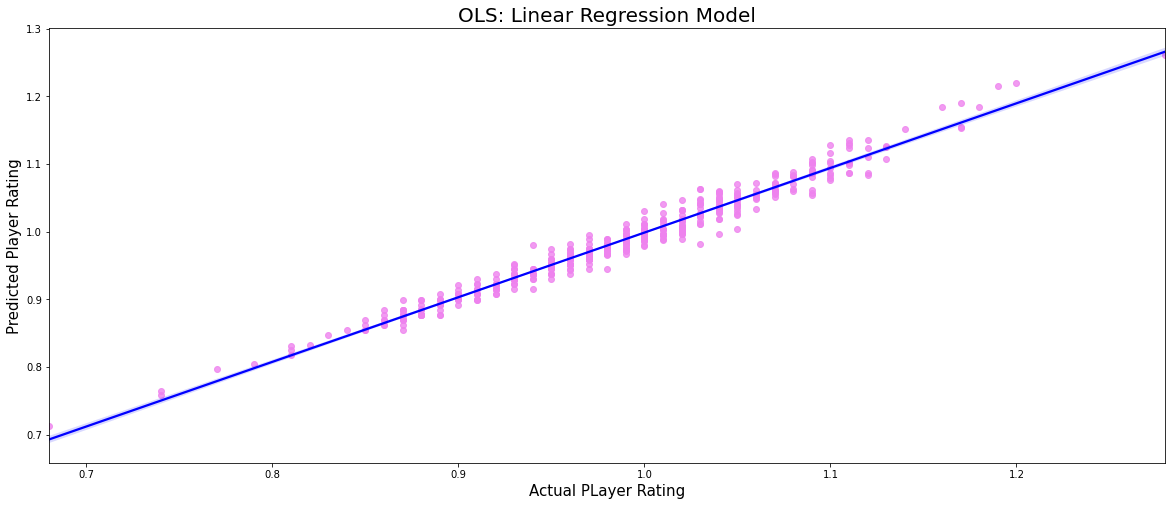

In [53]:
#looks like OLS did the best, let's visualize that
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_validate.rating, y=y_validate.rating_pred_lm, 
            scatter_kws={'color':'violet'}, line_kws={'color':'blue'})
plt.xlabel("Actual PLayer Rating", fontdict={'fontsize':15})
plt.ylabel("Predicted Player Rating", fontdict={'fontsize':15})
plt.title("OLS: Linear Regression Model", fontdict={'fontsize': 20})

plt.show()

### Testing OLS Model

In [54]:

print('Baseline')
print('-----------------------------')
print('RMSE using Mean\nTrain/In-Sample: ', round(rmse_train, 4), 
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 4))
print('-----------------------------')

## RMSE of tax_value_pred_median train and validate scores
rmse_train = mean_squared_error(y_train.rating, y_train.rating_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.rating, y_validate.rating_pred_mean)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

## R squared score for baseline
print('-----------------------------')
r2_baseline = r2_score(y_validate.rating, y_validate.rating_pred_mean)
print(f'The R squared score for the baseline is {r2_baseline}')




# predicting on our test model
y_test['rating_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.rating, y_test.rating_pred_lm)**(1/2)
print('             ')
print('             Our Test Model')
print('-----------------------------------------')
print("RMSE for OLS Model\nTest Performance: ", rmse_test)
r2_test_score_lm = r2_score(y_test.rating, y_test.rating_pred_lm)
print(f'OLS: Linear Regression has an R^2 value of {round(r2_test_score_lm,4)}')

Baseline
-----------------------------
RMSE using Mean
Train/In-Sample:  0.0147 
Validate/Out-of-Sample:  0.0135
-----------------------------
RMSE using Median
Train/In-Sample:  0.0748 
Validate/Out-of-Sample:  0.0773
-----------------------------
The R squared score for the baseline is -0.00011947189339411857
             
             Our Test Model
-----------------------------------------
RMSE for OLS Model
Test Performance:  0.014141253746400476
OLS: Linear Regression has an R^2 value of 0.9648


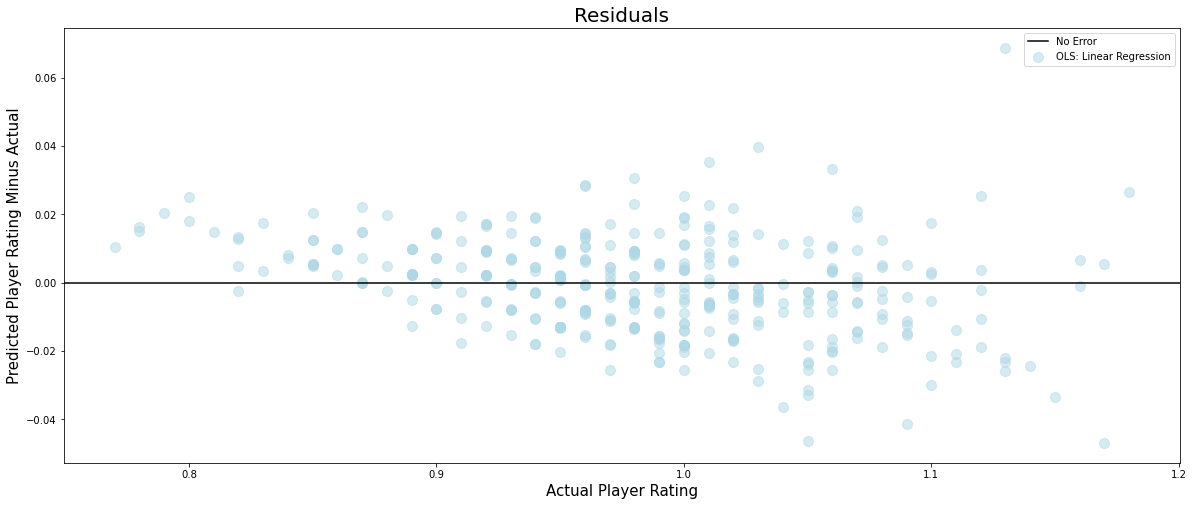

In [55]:
plt.figure(figsize=(20,8)) ## only OLS looking at test
plt.axhline(label="No Error", color="black")
plt.scatter(y_test.rating, y_test.rating_pred_lm-y_test.rating, 
            alpha=.5, color="lightblue", s=100, label="OLS: Linear Regression")
plt.legend()
plt.xlabel("Actual Player Rating", fontdict={'fontsize':15})
plt.ylabel("Predicted Player Rating Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})
plt.show()

Our OLS: Linear Regression performs better than the baseline and has the highest R squared value so we used it on our test dataset¶


#### Takeaways from Test/ Final Takeaways¶


 - player kd and kd_diff were the best drivers in predicting player rating because they had the strongest correlation and proved significant with correlation testing
 - This model could be used as a baseline in esport specifically Counter Strike to provide an efficient and quick player rating system
